### 初始化

In [1]:
data_path = "/home/sonwe1e/WorkStation/Dataset/MNIST/"
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

data = np.load(data_path + "mnist.npz")["x_train"]
data = torch.from_numpy(data).float()
data = data.unsqueeze(1) / data.max()
data = transforms.Resize((32, 32))(data)
print(data.shape, data.max())

torch.Size([60000, 1, 32, 32]) tensor(1.)


/home/sonwe1e/miniconda3/envs/cv2d/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


### 定义相关函数

In [3]:
def corrupt(x, rate):
    noise = torch.rand_like(x)
    rate = rate.view(-1, 1, 1, 1)
    x = x * (1 - rate) + noise * rate
    return x

### 绘制损坏图像

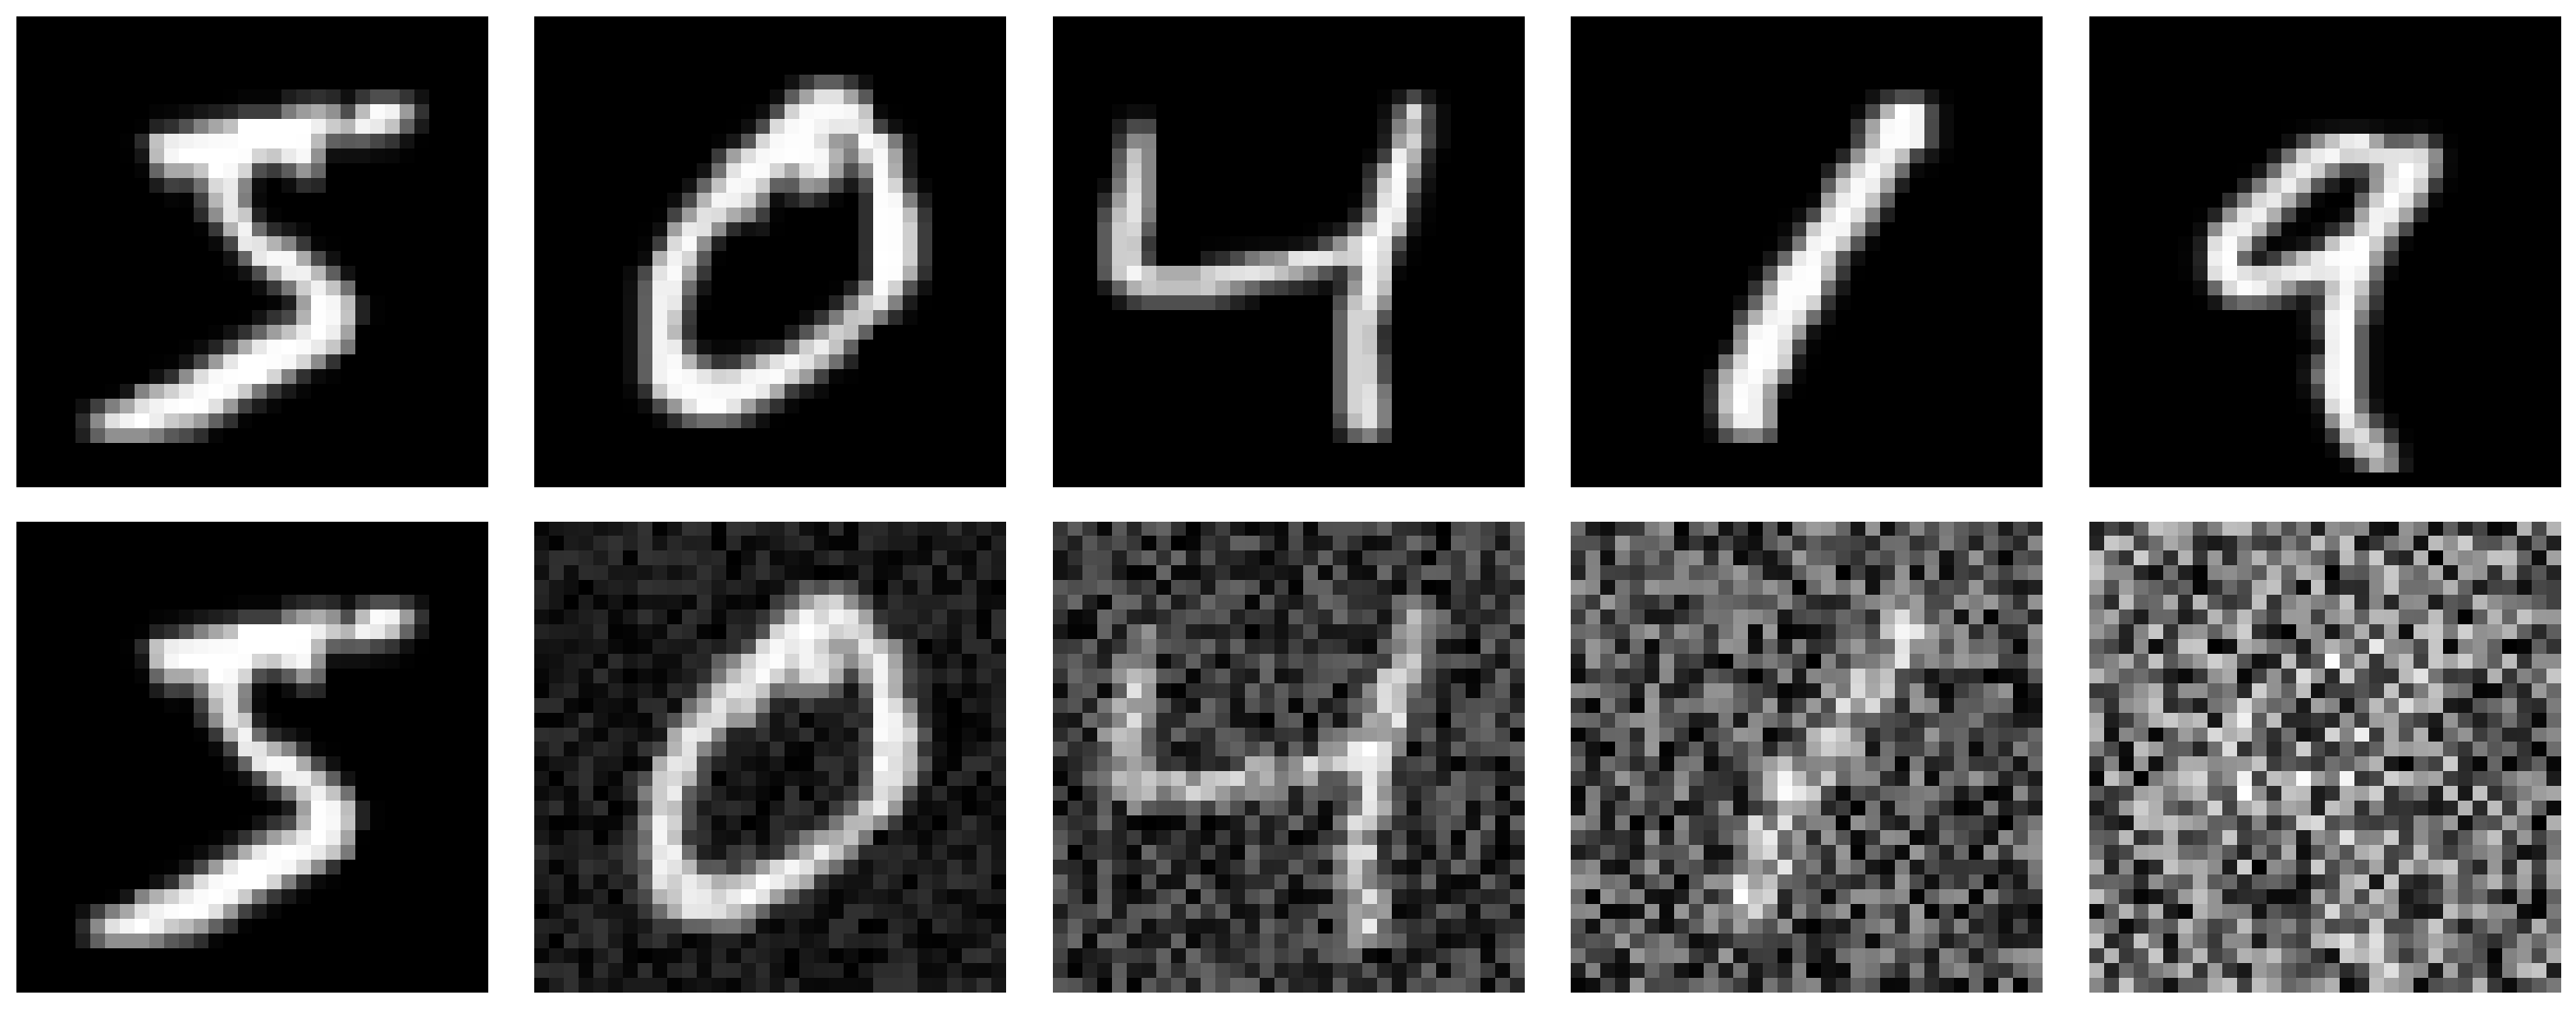

In [4]:
plt.rcParams["figure.figsize"] = (20.0, 8.0)
plt.rcParams["figure.dpi"] = 200

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.axis("off")
    plt.imshow(data[i : i + 1][0, 0], cmap="gray")
    plt.subplot(2, 5, i + 6)
    plt.axis("off")
    plt.imshow(corrupt(data[i : i + 1], torch.tensor(i) * 0.2)[0, 0], cmap="gray")
plt.subplots_adjust(wspace=0.1, hspace=0.0)  # 调整子图间的水平和垂直间隙
plt.show()

### 准备训练数据

  0%|          | 0/117 [00:00<?, ?it/s]

100%|██████████| 117/117 [00:16<00:00,  6.89it/s]


Finished epoch 0. Average loss for this epoch: 0.02310


100%|██████████| 117/117 [00:17<00:00,  6.88it/s]


Finished epoch 1. Average loss for this epoch: 0.01178


100%|██████████| 117/117 [00:16<00:00,  6.90it/s]


Finished epoch 2. Average loss for this epoch: 0.01057


100%|██████████| 117/117 [00:16<00:00,  6.89it/s]


Finished epoch 3. Average loss for this epoch: 0.00978


100%|██████████| 117/117 [00:16<00:00,  6.90it/s]


Finished epoch 4. Average loss for this epoch: 0.00923


100%|██████████| 117/117 [00:17<00:00,  6.87it/s]


Finished epoch 5. Average loss for this epoch: 0.00885


100%|██████████| 117/117 [00:16<00:00,  6.89it/s]


Finished epoch 6. Average loss for this epoch: 0.00844


100%|██████████| 117/117 [00:17<00:00,  6.88it/s]


Finished epoch 7. Average loss for this epoch: 0.00833


100%|██████████| 117/117 [00:16<00:00,  6.88it/s]


Finished epoch 8. Average loss for this epoch: 0.00805


100%|██████████| 117/117 [00:16<00:00,  6.89it/s]

Finished epoch 9. Average loss for this epoch: 0.00797


(0.0, 0.1)

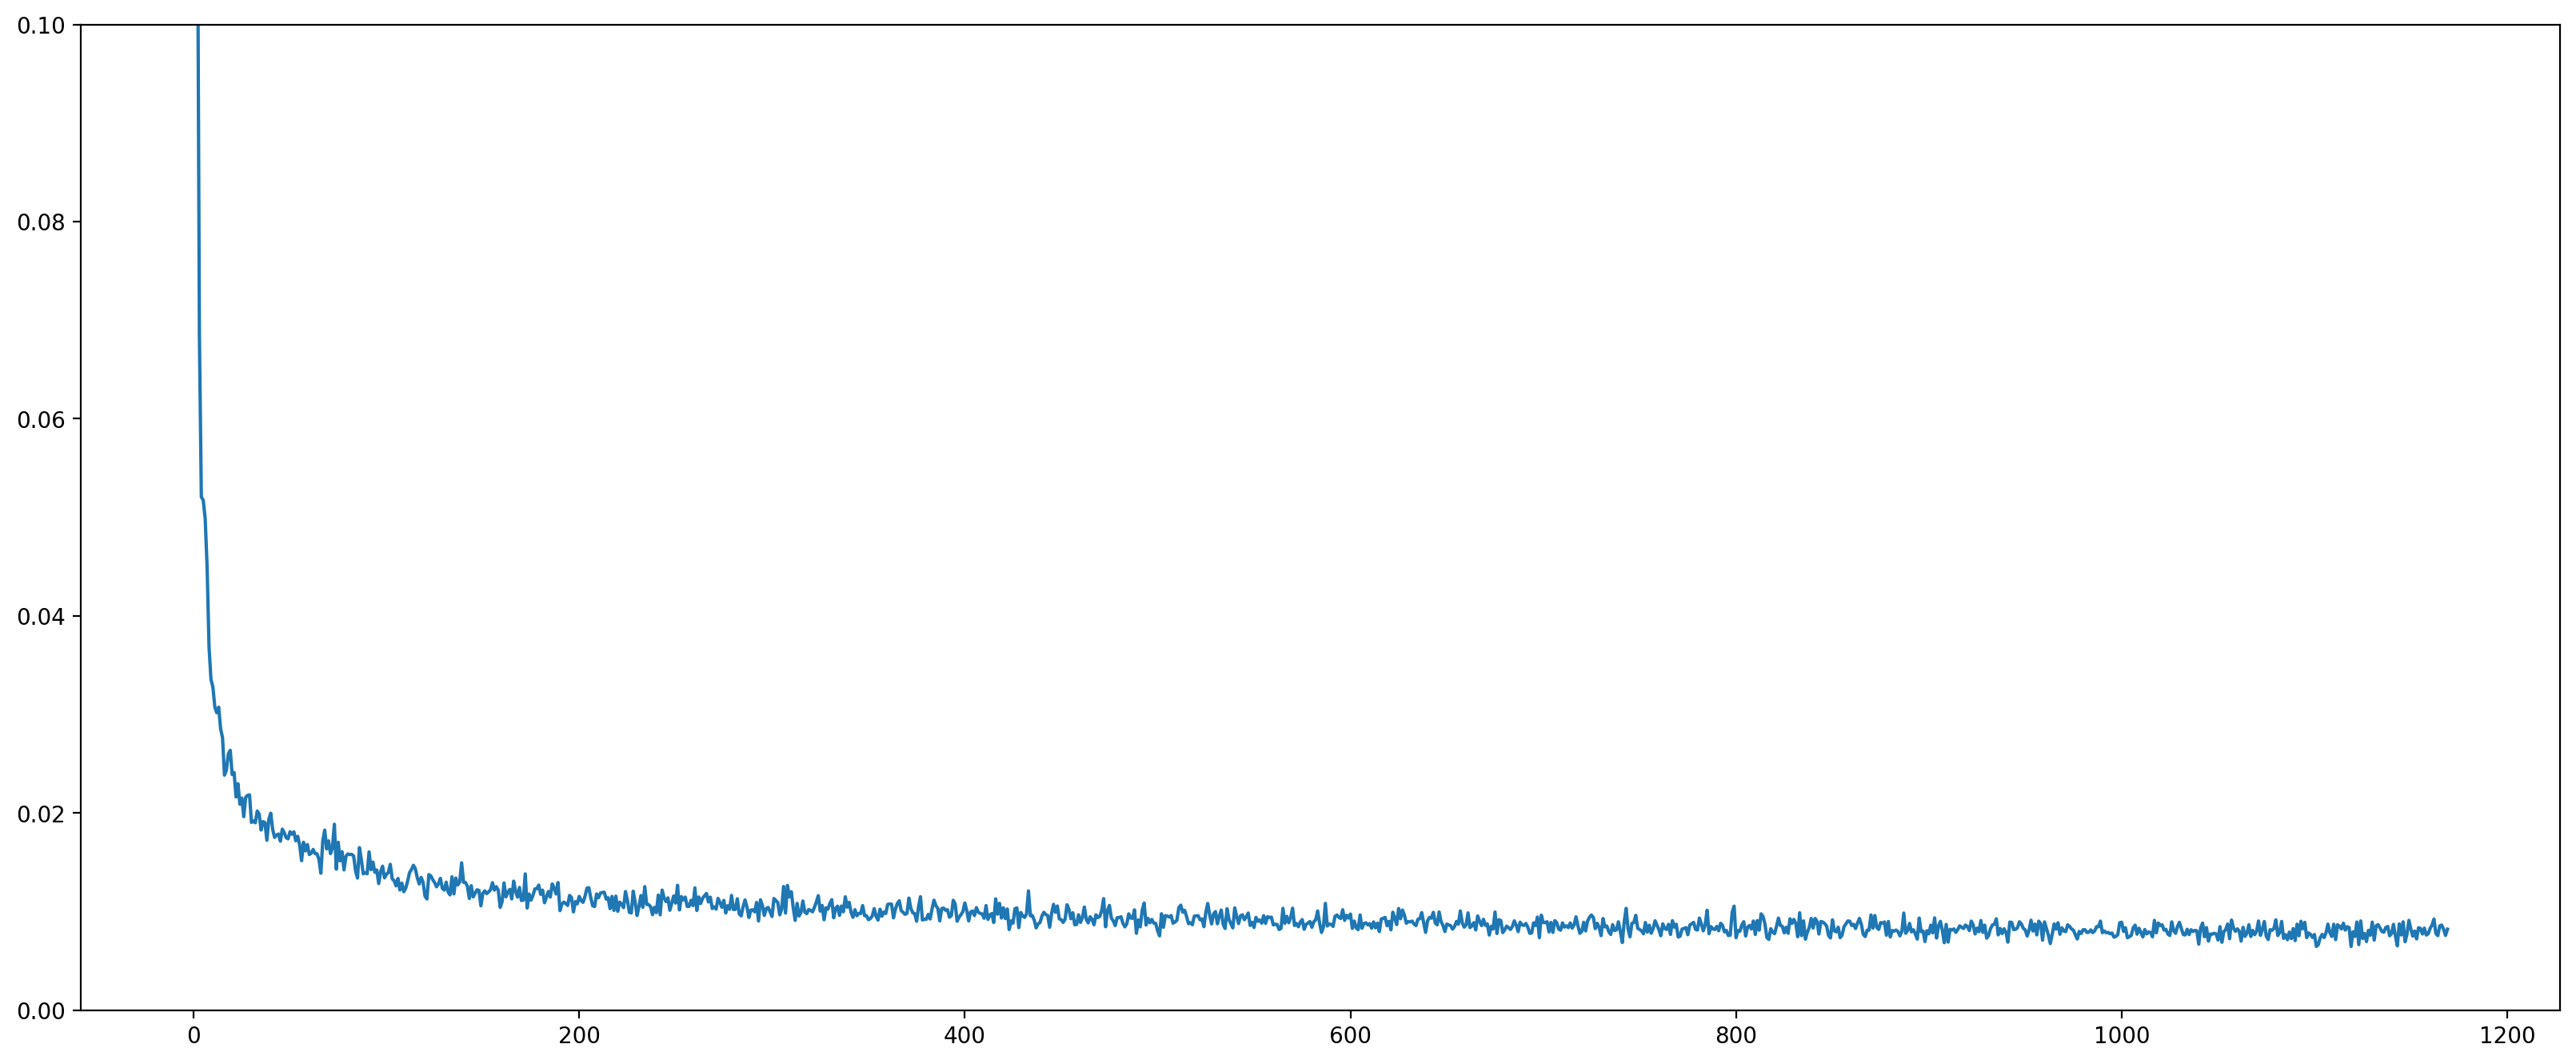

In [9]:
batch_size = 512
dataset = TensorDataset(data)
train_dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
    drop_last=True,
)

n_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from Unet import DDPM_Unet

model = DDPM_Unet(1, [32, 32, 64]).cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

losses = []
for epoch in range(n_epochs):
    for x in tqdm(train_dataloader):
        x = x[0].to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        # Get the model prediction
        t = torch.ones(size=(x.shape[0],), dtype=torch.long, device=device)
        pred = model(noisy_x, t)

        # Calculate the loss
        loss = criterion(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average loss for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:.5f}")

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

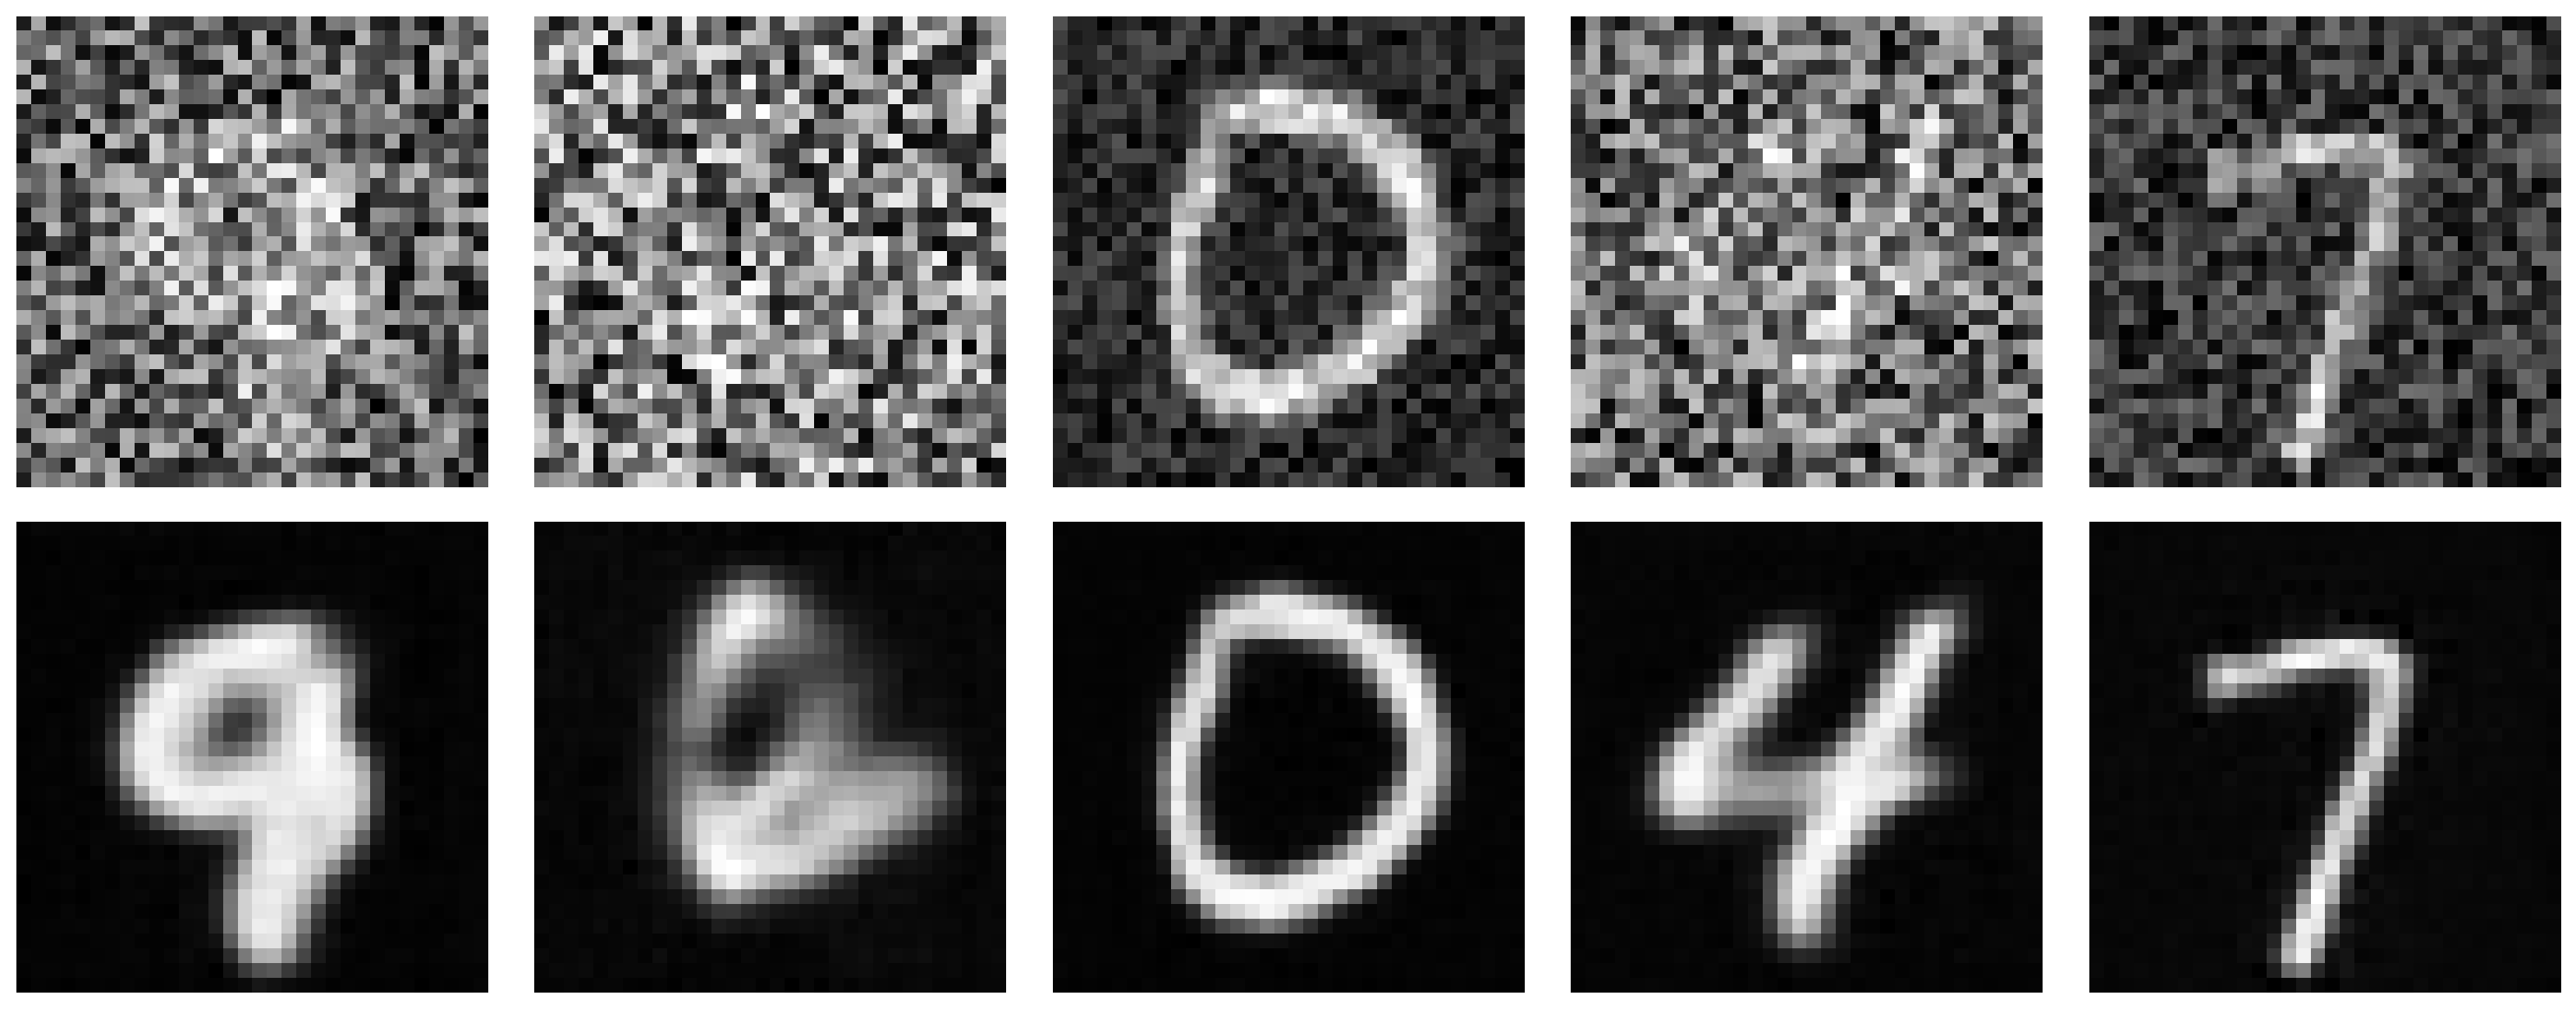

In [10]:
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.axis("off")
    plt.imshow(noisy_x[i : i + 1][0, 0].cpu().detach(), cmap="gray")
    plt.subplot(2, 5, i + 6)
    plt.axis("off")
    plt.imshow(pred[i : i + 1][0, 0].cpu().detach(), cmap="gray")
plt.subplots_adjust(wspace=0.1, hspace=0.0)  # 调整子图间的水平和垂直间隙
plt.show()

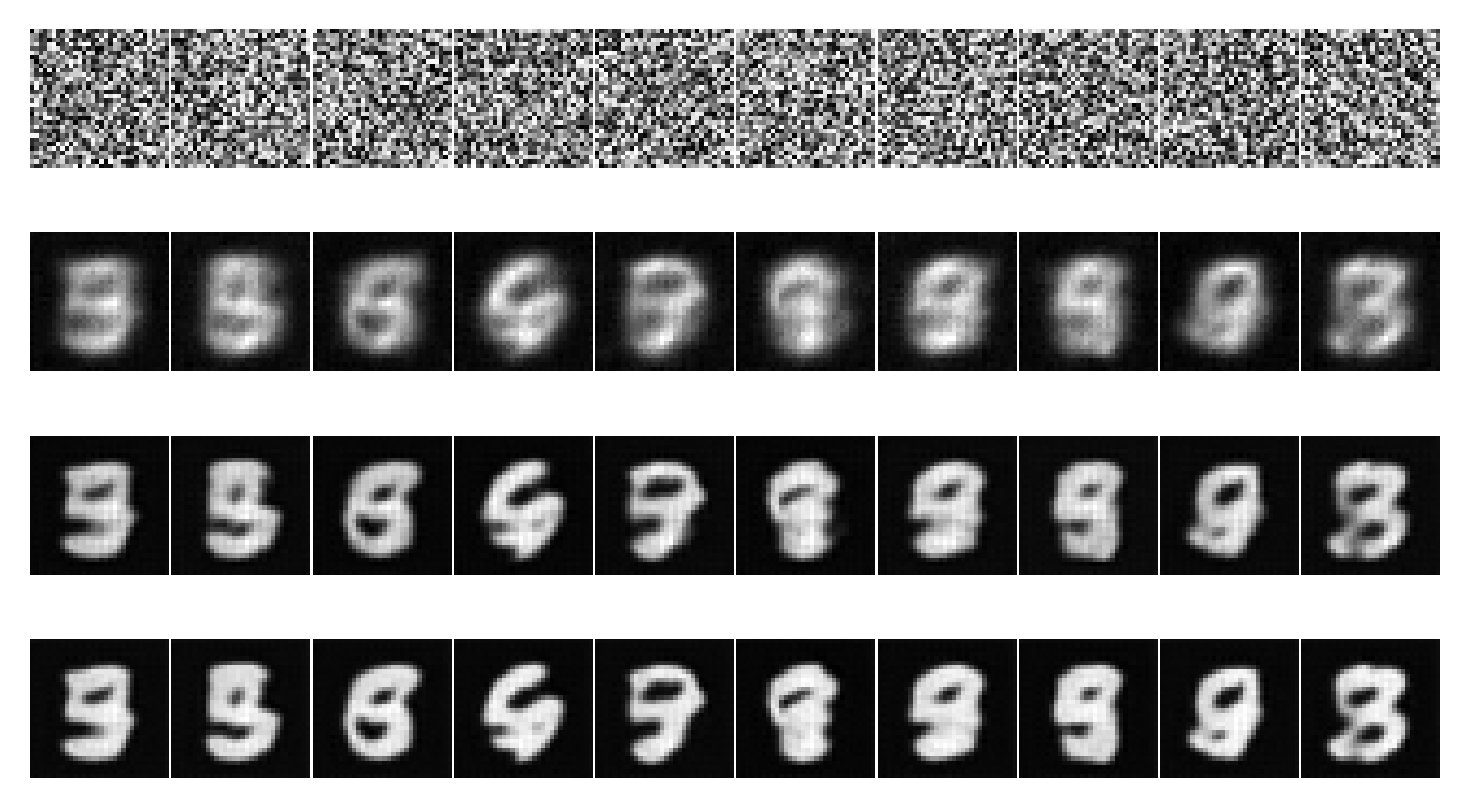

In [11]:
model.eval()
with torch.no_grad():
    pure_noise = torch.rand(10, 1, 32, 32).to(device)
    pred1 = model(pure_noise, t[:10])
    pred2 = model(pred1, t[10:20])
    for i in range(20):
        pred3 = model(pred2, t[20:30])
plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams["figure.dpi"] = 300
h, n = 4, 10
for i in range(n):
    plt.subplot(h, n, i + 1)
    plt.axis("off")
    plt.imshow(pure_noise[i : i + 1][0, 0].cpu().detach(), cmap="gray")
    plt.subplot(h, n, i + n + 1)
    plt.axis("off")
    plt.imshow(pred1[i : i + 1][0, 0].cpu().detach(), cmap="gray")
    plt.subplot(h, n, i + 2 * n + 1)
    plt.axis("off")
    plt.imshow(pred2[i : i + 1][0, 0].cpu().detach(), cmap="gray")
    plt.subplot(h, n, i + 3 * n + 1)
    plt.axis("off")
    plt.imshow(pred3[i : i + 1][0, 0].cpu().detach(), cmap="gray")
# 使用 tight_layout 自动调整子图大小和间隙
plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()